In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Thesis/reimp_lore")

import os
os.chdir('/content/drive/MyDrive/Thesis/reimp_lore')

# Now the directory '?' is the current working directory.

In [3]:
!pip install bitarray

In [4]:
!pip install scikit-multilearn

In [5]:
!pip install arff

In [6]:
import lore
from datamanager import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score

from util import record2str

ipynb to py in pycharm:
- jupyter nbconvert --to script new_run.ipynb

## Dataset

In [7]:
## Iris Dataset
# dataset_name = 'dataset/iris.csv'
# dataset = prepare_iris_dataset(dataset_name)

## wine
# dataset_name = 'dataset/wine.csv'
# dataset = prepare_wine_dataset(dataset_name)

##############################################
#           Categorical dataset              #
##############################################
## german: (0 = Good, 1 = Bad)
# dataset_name = 'dataset/german_credit.csv'
# dataset = prepare_german_dataset(dataset_name)

## adult: ['<=50K', '>50K']
# dataset_name = 'dataset/adult.csv'
# dataset = prepare_adult_dataset(dataset_name)

## compas-scores-two-years: ['High', 'Low', 'Medium']
dataset_name = 'dataset/compas-scores-two-years.csv'
dataset = prepare_compass_dataset(dataset_name)

dataframe = dataset[0]
class_name = dataset[1]
dataset_fin = prepare_dataset(dataframe, class_name)

In [8]:
df = dataset_fin[0] #dataframe with unique numeric class values(0, 1, ...)
feature_names = dataset_fin[1]
class_values = dataset_fin[2]
numeric_columns = dataset_fin[3]
rdf = dataset_fin[4] #real dataframe
real_feature_names = dataset_fin[5]
features_map = dataset_fin[6] #map each class name to its unique numeric value
df_categorical_idx = dataset_fin[7]

In [9]:
rdf.head()

,age,priors_count,days_b_screening_arrest,is_recid,is_violent_recid,two_year_recid,length_of_stay,age_cat,sex,race,c_charge_degree,class
0,69,0,1,0,0,0,0,Greater than 45,Male,Other,F,Low
1,34,0,1,1,1,1,10,25 - 45,Male,African-American,F,Low
2,24,4,1,1,0,1,1,Less than 25,Male,African-American,F,Low
3,23,1,1,0,0,0,0,Less than 25,Male,African-American,F,High
4,43,2,1,0,0,0,0,25 - 45,Male,Other,F,Low


In [10]:
df.head()

,age,priors_count,days_b_screening_arrest,is_recid,is_violent_recid,two_year_recid,length_of_stay,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,sex=Female,sex=Male,race=African-American,race=Asian,race=Caucasian,race=Hispanic,race=Native American,race=Other,c_charge_degree=F,c_charge_degree=M,class
0,69,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1
1,34,0,1,1,1,1,10,1,0,0,0,1,1,0,0,0,0,0,1,0,1
2,24,4,1,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,1,0,1
3,23,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0
4,43,2,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1


## Black box classifier

In [11]:
X = df.loc[:, df.columns != class_name].values
y = df[class_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
blackbox = RandomForestClassifier()
blackbox.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
y_pred = blackbox.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.591


## select an instance _x_

In [13]:
i = 10
x = X_test[i]
y_val = blackbox.predict(x.reshape(1,-1))[0]

print(class_values)
class_prob = blackbox.predict_proba(x.reshape(1,-1))[0]
print(class_prob)

y_val_name = class_values[y_val]
print('blackbox(x) = { %s }' % y_val_name)


['High', 'Low', 'Medium']
[0.   0.91 0.09]
blackbox(x) = { Low }


In [14]:
print('x = %s' % record2str(x, feature_names, numeric_columns))

x = { age = 29, priors_count = 0, days_b_screening_arrest = 3, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Female, race = African-American, c_charge_degree = F }


# LORE explainer (explaining an instance x)

In [15]:
lore_obj = lore.LORE(X_test, blackbox, feature_names, class_name, class_values,
                 numeric_columns, features_map, df_categorical_idx, neigh_type='ngmusx', verbose=False)

In [16]:
# just to check
# Z = lore_obj.neighgen_fn(x, categorical_columns=df_categorical_idx)
# print('Z is:',Z)
# Z.shape

In [17]:
explanation = lore_obj.explain_instance(x, samples=1000, nbr_runs=10, exemplar_num=3)
print(explanation)

r = { race != Caucasian, length_of_stay <= 0.50 } --> { class: Low }

feature importance = {'length_of_stay': 0.3442295650956823, 'race=Caucasian': 0.2879910078774561}

c = { { race = Caucasian } --> { class: Medium } }

exemplars = { age = 28, priors_count = 0, days_b_screening_arrest = 2, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Male, race = African-American, c_charge_degree = M }
{ age = 28, priors_count = 1, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Female, race = African-American, c_charge_degree = F }
{ age = 28, priors_count = 0, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Male, race = African-American, c_charge_degree = F }

counter-exemplars = { age = 29, priors_count = 1, days_b_screening_arrest = 3, is_recid = 1, is_violent_recid = 0, two_year_r

# X-Bot

In [18]:
!ls

 best_xbot_model.h5   __init__.py		  README.md
 chatdata	      lore.py			  response_generator_keras.py
 classes.pkl	      neighborgen_lore.py	  rule.py
 datamanager.py       new_run_seq2seq.ipynb	  util.py
 dataset	     'new_run with keras.ipynb'   words.pkl
 decision_tree.py     new_run_with_keras.py	  xbot_model.py
 explanation.py       __pycache__


### Model

In [19]:
!pip install symspellpy

In [20]:
from response_generator_keras import ResponseGeneratorKeras
from xbot_model import XBotModel
from keras.models import load_model

import json
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
###################### Chat Data ######################
data_file = open('chatdata/intents.json').read()
data = json.loads(data_file)

In [22]:
XBot_obj = XBotModel(verbose=True)

In [23]:
# train dataset
train_dataset = XBot_obj.prepare_train_dataset(data)
train_x = list(train_dataset[:, 0])
train_y = list(train_dataset[:, 1])

Training data created!


In [24]:
# create model
model = XBot_obj.create_model(train_x, train_y, dropout=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12672     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# compile and fit the model
mymodel = XBot_obj.compile_fit_model(model, train_x, train_y, epochs=100, 
                                     batch_size=5,
                                     lr=5e-3,
                                     earlystopping_patience=20,
                                     loss='categorical_crossentropy')

Epoch 1/100
8/8 [==============================] - 1s 76ms/step - loss: 2.4355 - accuracy: 0.0409 - val_loss: 2.2975 - val_accuracy: 0.1176
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 2.1212 - accuracy: 0.2067 - val_loss: 2.2395 - val_accuracy: 0.1765
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 2.0072 - accuracy: 0.3547 - val_loss: 2.2102 - val_accuracy: 0.1765
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 1.7473 - accuracy: 0.5088 - val_loss: 2.1500 - val_accuracy: 0.1765
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 1.6428 - accuracy: 0.5417 - val_loss: 2.1139 - val_accuracy: 0.1765
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 1.2850 - accuracy: 0.5757 - val_loss: 2.0805 - val_accuracy: 0.2353
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 1.3064 - accuracy: 0.6882 - val_loss: 1.9840 - val_accuracy: 0.2941
Epoch 8/100
8/8 [=========

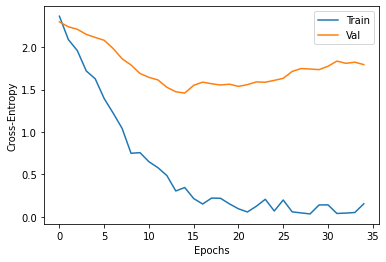

In [26]:
# plot the Train and Validation loss
plt.plot(mymodel['loss'], label='Train')
plt.plot(mymodel['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

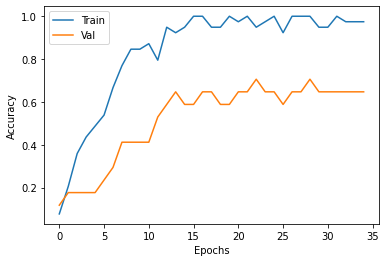

In [27]:
# plot the Train and Validation accuracy
plt.plot(mymodel['accuracy'], label='Train')
plt.plot(mymodel['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
trained_model = load_model('best_xbot_model.h5')

_, accuracy = trained_model.evaluate(train_x, train_y)
print('Train Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 8ms/step - loss: 0.4852 - accuracy: 0.8750
Train Accuracy: 87.50


### Chatbot

In [ ]:
xbot_response = ResponseGeneratorKeras(data, explanation, trained_model)

xbot_response.start()

Hello, I'm X-Bot!
If you want to exit, type Bye!
hi
X-Bot: Buongiorno


hllo
X-Bot: Hello


how about the performance
X-Bot: The fidelity is: 
1.0


how about the perfromance
X-Bot: The fidelity is: 
1.0


give me a exemplar
X-Bot: The exemplars are: 
{ age = 28, priors_count = 0, days_b_screening_arrest = 2, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Male, race = African-American, c_charge_degree = M }
{ age = 28, priors_count = 1, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Female, race = African-American, c_charge_degree = F }
{ age = 28, priors_count = 0, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 0, age_cat = 25 - 45, sex = Male, race = African-American, c_charge_degree = F }


feature importance
X-Bot: The most important features are: 
{'length_of_stay': 0.3442295650956823, 'race=